In [ ]:
# Add regularization to linear regression. Makes it applicable for 
# ill-posed problems (e.g. # predictors >> # samples) and helps prevent
# overfitting.

# Regularized Linear Regression

# Want to pick model that strikes the right balance of having enough complexity
# to model the relationship between the predictors and response, while not
# fitting the idiosyncrasies of the training data, which will make it unable
# to generalize and predict unseen cases well.

# Let's illustrate with simple curve fitting example.


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


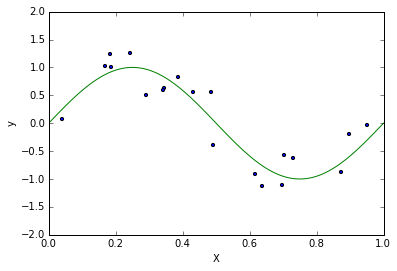

In [2]:
%pylab inline

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.cross_validation import train_test_split

try:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
except ImportError:
    # Use backports for sklearn 1.4
    # available from https://s3.amazonaws.com/datarobotblog/notebooks/sklearn_backports.py
    from sklearn_backports import PolynomialFeatures
    from sklearn_backports import make_pipeline
    
#ignore DepreciateWarnings by sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np,random.seed(9)

def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

ax = plt.gca()
ax.plot(x_plot, f(x_plot), color='green')
ax.scatter(X_train, y_train, s=10)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('X')


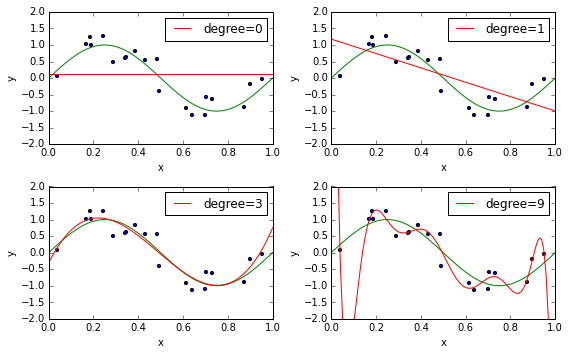

In [4]:
# now let's see how different polynomials can approximate this curve

def plot_approximation(est, ax, label=None):
    """Plot the approximation of est on axis ax"""
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(X_train, y_train, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right') #, fontsize='small')
    
fig,axes = plt.subplots(2, 2, figsize=(8, 5))
for ax, degree in zip(axes.ravel(), [0, 1, 3, 9]):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    plot_approximation(est, ax, label='degree=%d' % degree)
        
plt.tight_layout()    

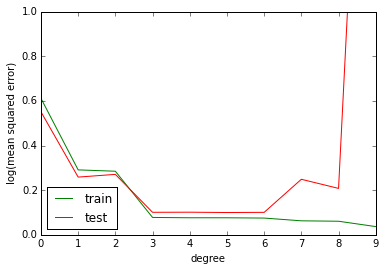

In [5]:
# Above we see example of overfitting

from sklearn.metrics import mean_squared_error

train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))
    
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim(0.0, 1e0)
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='lower left')
    

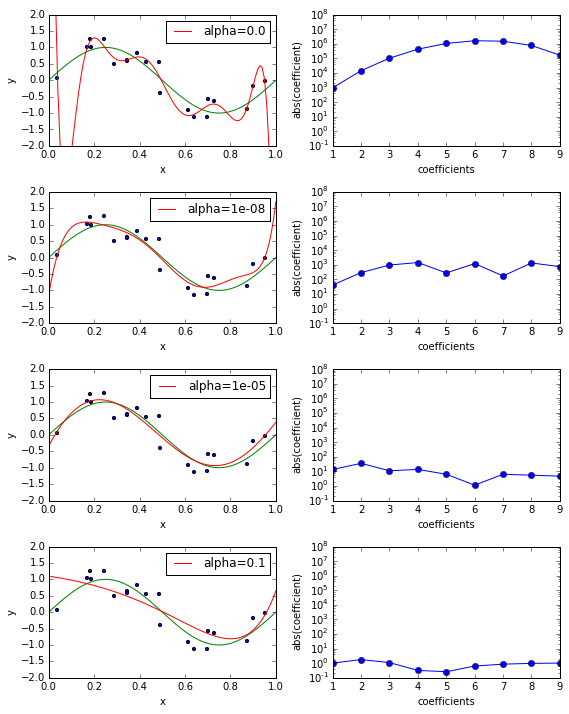

In [6]:
# Add constraint to to linear regression model that constrains magnitude
# of the coefficients in the regression model. The constraint is called 
# the regularization term and the technique is often called shrinkage
# b/c it shrinks the coefficients towards zero. In context of polynomial
# regression, constraining the magnitude of the regression coefficients 
# effectively is a smoothness assumption: by constraining the L2 norm
# of the regression coefficients we express our preference for smooth
# functions rather than wiggly ones.

# A popular regularized linear regression model is Ridge Regression. This adds
# the L2 norm of the coefficients to the ordinary
# least squares objective

# here we fit polynomial of degree nine for various values of alpha (left)
# the smaller the vlaue of alpha the higher the magnitude of the coefficients

fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))

def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row, in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)
    
plt.tight_layout()

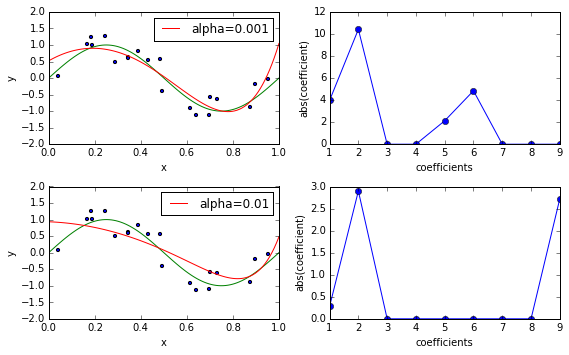

In [8]:
# Three types of regularization
# Ridge (L2), Lasso (L1), Elastic Net

# sklearn uses coordinate descent to solve EN and Lasso solutions

from sklearn.linear_model import Lasso

fig, ax_rows = plt.subplots(2, 2, figsize=(8, 5))

degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)
    
plt.tight_layout()